In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from dateutil.parser import parse
import numpy as np
import seaborn as sns
import warnings
import datetime as dt
warnings.filterwarnings('ignore')
from IPython.display import Image
from IPython.display import HTML
from wordcloud import WordCloud, STOPWORDS

In [2]:
events = pd.read_csv('data/events.csv')
events.head()

,timestamp,event,person,url,sku,model,condition,storage,color,skus,...,search_engine,channel,new_vs_returning,city,region,country,device_type,screen_resolution,operating_system_version,browser_version
0,2018-05-31 23:38:05,ad campaign hit,0004b0a2,/comprar/iphone/iphone-5s,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-05-31 23:38:05,visited site,0004b0a2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Paid,New,Camaragibe,Pernambuco,Brazil,Smartphone,360x640,Android 6,Chrome Mobile 39
2,2018-05-31 23:38:09,viewed product,0004b0a2,NaN,2694,iPhone 5s,Bom,32GB,Cinza espacial,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-05-31 23:38:40,checkout,0004b0a2,NaN,2694,iPhone 5s,Bom,32GB,Cinza espacial,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-05-29 13:29:25,viewed product,0006a21a,NaN,15338,Samsung Galaxy S8,Bom,64GB,Dourado,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
events.describe()

,timestamp,event,person,url,sku,model,condition,storage,color,skus,...,search_engine,channel,new_vs_returning,city,region,country,device_type,screen_resolution,operating_system_version,browser_version
count,1011288,1011288,1011288,82756,563838.0,564284,563836,563836,563836,221699,...,50957,87378,87378,87378,87378,87378,87378,87378,87378,87378
unique,793805,11,27624,227,3885.0,202,5,8,63,35310,...,4,7,2,1939,93,46,4,282,121,343
top,2018-05-15 15:56:06,viewed product,71492f2b,/,2830.0,iPhone 6,Bom,16GB,Preto,"2820,6706,6720,2750,6649,7251,6663,12604,7224,...",...,Google,Paid,Returning,Unknown,Sao Paulo,Brazil,Smartphone,360x640,Windows 7,Chrome 66.0
freq,11,528931,2771,28323,4311.0,50916,243014,190833,132960,594,...,50240,44193,60480,15819,24996,84308,44239,30009,19675,22611


In [4]:
events.columns

Index(['timestamp', 'event', 'person', 'url', 'sku', 'model', 'condition',
       'storage', 'color', 'skus', 'search_term', 'staticpage',
       'campaign_source', 'search_engine', 'channel', 'new_vs_returning',
       'city', 'region', 'country', 'device_type', 'screen_resolution',
       'operating_system_version', 'browser_version'],
      dtype='object')

# Limpieza del Set de Datos

In [5]:
#Eliminamos la columna "url" ya que no proporciona ningun tipo de informacion siendo el valor top "/"
#Tambien la columna "skus" ya que nos vamos a enfocar en la columna "sku" del id del producto
#y la columna "city" ya que el valor top es "Unknown" y alcanza con analizar region y country
#Ademas, eliminamos la columna "search_engine" ya que siendo Google el top de búsqueda, algo que nos parece predecible.
events.drop(['url','skus','city','search_engine','campaign_source','channel'], inplace=True, axis=1)

In [6]:
#Cambiamos el tipo de dato de fecha de timestamp a datetime para un mejor analisis y renombramos a "fecha"
events[['timestamp']] = events[['timestamp']].apply(pd.to_datetime)
events.rename({
    'timestamp' : 'fecha',
}, axis=1, inplace=True)
events.head()

,fecha,event,person,sku,model,condition,storage,color,search_term,staticpage,new_vs_returning,region,country,device_type,screen_resolution,operating_system_version,browser_version
0,2018-05-31 23:38:05,ad campaign hit,0004b0a2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-05-31 23:38:05,visited site,0004b0a2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,Pernambuco,Brazil,Smartphone,360x640,Android 6,Chrome Mobile 39
2,2018-05-31 23:38:09,viewed product,0004b0a2,2694,iPhone 5s,Bom,32GB,Cinza espacial,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-05-31 23:38:40,checkout,0004b0a2,2694,iPhone 5s,Bom,32GB,Cinza espacial,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-05-29 13:29:25,viewed product,0006a21a,15338,Samsung Galaxy S8,Bom,64GB,Dourado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Verifico que no hay registros que no tienen event cargado en el DataFrame
print (events['event'].size == events['event'].count())

True


In [8]:
#Analizar cuál es el tipo de evento predominante en el set de datos. 
#Eventos predominantes (total 11)
pred_event = events.loc[:, ['event']]
pred_event= pred_event.groupby('event').size() 
pred_event = pred_event.reset_index()
pred_event.rename({
    0:'count'
}, axis=1, inplace=True)
pred_event.sort_values(by='count', ascending=False, inplace=True)
pred_event.head(11)

,event,count
9,viewed product,528931
1,brand listing,98635
10,visited site,87378
0,ad campaign hit,82827
4,generic listing,67534
7,searched products,56073
6,search engine hit,50957
2,checkout,33735
8,staticpage,3598
3,conversion,1172


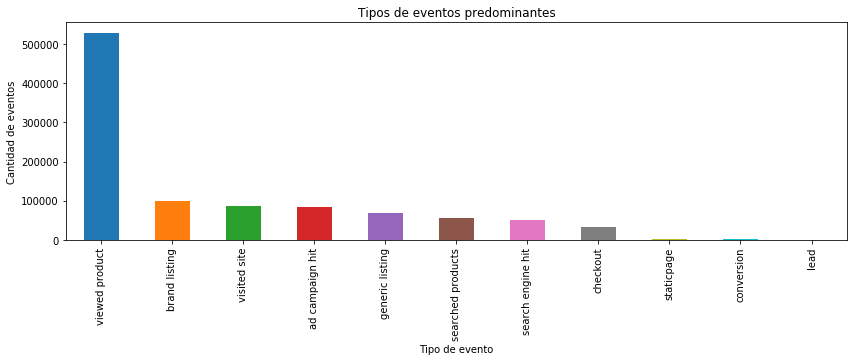

In [9]:
plot_event = pred_event.plot(x='event', y='count', title = "Tipos de eventos predominantes",kind='bar',figsize=(14,4))
plot_event.set_ylabel('Cantidad de eventos')
plot_event.set_xlabel('Tipo de evento')
plot_event.legend().set_visible(False)
plt.show()

In [10]:
#Top viewed products by model
devices = events.loc[:,['event', 'model','device_type']]
devices = devices.loc[devices.event == 'viewed product']
devices = devices.loc[:,['model']]
devices = devices.groupby('model').size()
devices = devices.reset_index()
devices.rename({
    0:'count'
}, axis=1, inplace=True)
devices.sort_values(by='count', ascending=False, inplace=True)
devices.head(10)

,model,count
190,iPhone 6,47538
189,iPhone 5s,42045
192,iPhone 6S,36930
194,iPhone 7,26330
132,Samsung Galaxy S7 Edge,23062
131,Samsung Galaxy S7,18085
195,iPhone 7 Plus,17853
198,iPhone SE,15874
133,Samsung Galaxy S8,15868
193,iPhone 6S Plus,12250


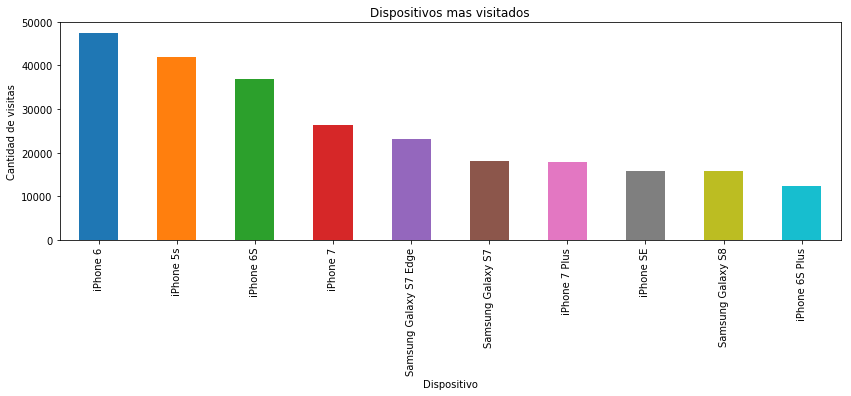

In [11]:
plot_device = devices.head(10)
plot_device = plot_device.plot(x='model', y='count', title = "Dispositivos mas visitados",kind='bar',figsize=(14,4))
plot_device.set_ylabel('Cantidad de visitas')
plot_device.set_xlabel('Dispositivo')
plot_device.legend().set_visible(False)
plt.show()

# Analisis de visitas en el sitio

In [12]:
visitas = events.loc[:,['event','fecha','person','new_vs_returning','region','country','device_type','screen_resolution','operating_system_version','browser_version']]
visitas = visitas.loc[visitas.event == 'visited site']
visitas.browser_version = visitas.browser_version.apply(lambda x: x.split(' ')[0])
visitas.browser_version = visitas.browser_version.apply(lambda x: 'Chrome' if 'Mobile' == x else x)
visitas.head()

,event,fecha,person,new_vs_returning,region,country,device_type,screen_resolution,operating_system_version,browser_version
1,visited site,2018-05-31 23:38:05,0004b0a2,New,Pernambuco,Brazil,Smartphone,360x640,Android 6,Chrome
5,visited site,2018-05-29 13:29:26,0006a21a,New,Rio de Janeiro,Brazil,Smartphone,360x640,Android 5.1.1,Android
9,visited site,2018-04-09 20:12:31,000a54b2,New,Rio de Janeiro,Brazil,Computer,1920x1080,Windows 10,Chrome
16,visited site,2018-05-24 11:21:07,000a54b2,Returning,Rio de Janeiro,Brazil,Computer,1920x1080,Windows 10,Chrome
45,visited site,2018-04-06 05:12:05,00184bf9,New,Sao Paulo,Brazil,Computer,1366x768,Windows 10,Chrome


### Relacion de visitas en el sitio por dia y hora de la semana

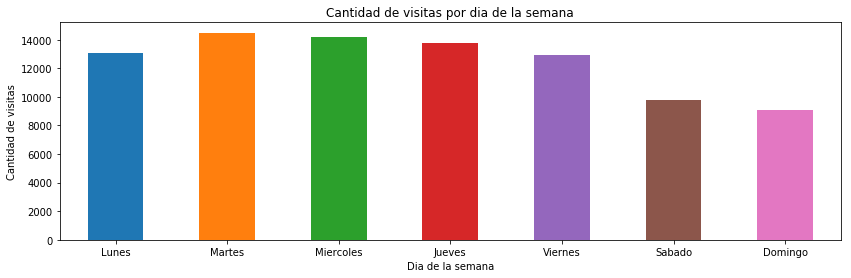

In [13]:
visitas_dias = visitas.loc[:,['event', 'fecha']]

visitas_dias['weekday'] = visitas_dias['fecha'].dt.weekday_name
visitas_dias['dayofweek'] = visitas_dias['fecha'].dt.dayofweek
visitas_dias_groupby = visitas_dias.groupby(['dayofweek','weekday']).count()['fecha'].reset_index()
visitas_dias_groupby.set_index('weekday', inplace=True)
visitas_dias_groupby.drop('dayofweek', inplace=True, axis=1)
visitas_dias_groupby.index.name = None
visitas_dias_groupby.rename({
    'Monday' : 'Lunes',
    'Tuesday' : 'Martes',
    'Wednesday' : 'Miercoles',
    'Thursday' : 'Jueves',
    'Friday' : 'Viernes',
    'Saturday' : 'Sabado',
    'Sunday' : 'Domingo'
}, axis=0, inplace=True)

plot_visitas_dias = visitas_dias_groupby.plot(y='fecha', title = "Cantidad de visitas por dia de la semana",kind='bar',figsize=(14,4),rot=0)
plot_visitas_dias.set_ylabel('Cantidad de visitas')
plot_visitas_dias.set_xlabel('Dia de la semana')
plot_visitas_dias.legend().set_visible(False)
plt.show()

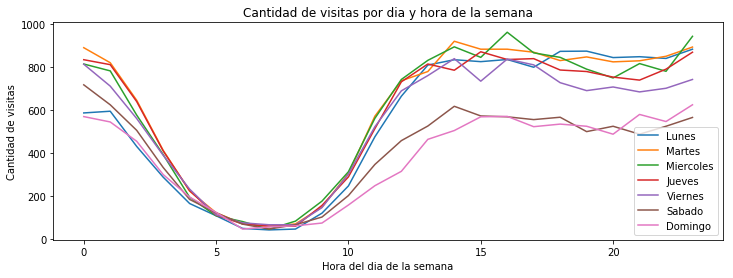

In [14]:
visitas_dyh = visitas_dias

visitas_dyh['hour'] = visitas_dyh['fecha'].dt.hour
visitas_dyh = visitas_dyh.loc[:,['event','weekday','hour']]

#separo por dia
lunes = visitas_dyh[visitas_dyh.weekday == 'Monday']
martes = visitas_dyh[visitas_dyh.weekday == 'Tuesday']
miercoles = visitas_dyh[visitas_dyh.weekday == 'Wednesday']
jueves = visitas_dyh[visitas_dyh.weekday == 'Thursday']
viernes = visitas_dyh[visitas_dyh.weekday == 'Friday']
sabado = visitas_dyh[visitas_dyh.weekday == 'Saturday']
domingo = visitas_dyh[visitas_dyh.weekday == 'Sunday']

#agrupo por hora por cada dia con la cantidad de postulaciones
lunes = lunes.groupby('hour', as_index=False)['event'].count()
lunes.columns = ['hour', 'Lunes']
martes = martes.groupby('hour', as_index=False)['event'].count()
martes.columns = ['hour', 'Martes']
miercoles = miercoles.groupby('hour', as_index=False)['event'].count()
miercoles.columns = ['hour', 'Miercoles']
jueves = jueves.groupby('hour', as_index=False)['event'].count()
jueves.columns = ['hour', 'Jueves']
viernes = viernes.groupby('hour', as_index=False)['event'].count()
viernes.columns = ['hour', 'Viernes']
sabado = sabado.groupby('hour', as_index=False)['event'].count()
sabado.columns = ['hour', 'Sabado']
domingo = domingo.groupby('hour', as_index=False)['event'].count()
domingo.columns = ['hour', 'Domingo']

#junto los dias
visitas_dyh = pd.merge(lunes, martes, on='hour', how="left")
visitas_dyh = pd.merge(visitas_dyh, miercoles, on='hour', how="left")
visitas_dyh = pd.merge(visitas_dyh, jueves, on='hour', how="left")
visitas_dyh = pd.merge(visitas_dyh, viernes, on='hour', how="left")
visitas_dyh = pd.merge(visitas_dyh, sabado, on='hour', how="left")
visitas_dyh = pd.merge(visitas_dyh, domingo, on='hour', how="left")

plot_visitas_dyh = visitas_dyh.plot(x='hour', title="Cantidad de visitas por dia y hora de la semana", figsize=(12,4))
plot_visitas_dyh.set_ylabel('Cantidad de visitas')
plot_visitas_dyh.set_xlabel('Hora del dia de la semana')
plt.show()

### Relacion de visitas en el sitio durante el año

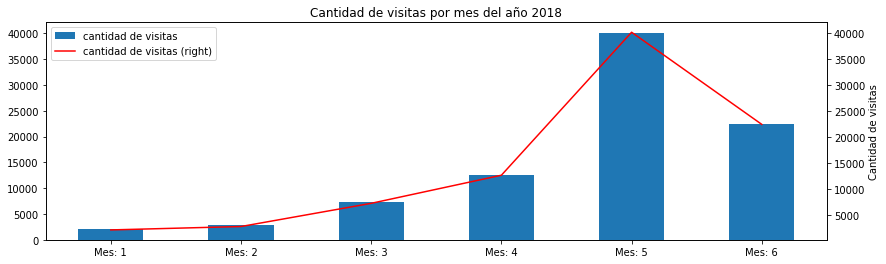

In [15]:
#Solo hay datos de 2018
#Por meses del anio 2018
visitas_anio = visitas.loc[:,['event', 'fecha']]
visitas_anio = visitas_anio.loc[visitas_anio['fecha'].dt.year  == 2018]
visitas_anio['fecha'] = "Mes: " + visitas_anio['fecha'].dt.month.astype(str)
visitas_anio_groupby = visitas_anio.groupby('fecha').count().reset_index()
visitas_anio_groupby.rename({'event' : 'cantidad de visitas'}, axis=1, inplace=True)
visitas_anio_groupby.set_index('fecha', inplace=True)
visitas_anio_groupby.index.name = None

ax = plt.gca()

visitas_anio_groupby.plot(rot=0, ax = ax, title = "Cantidad de visitas por mes del año 2018", kind='bar',figsize=(14,4))
visitas_anio_groupby.plot(rot=0, ax = ax, title = "Cantidad de visitas por mes del año 2018", kind='line',figsize=(14,4), secondary_y=True, color='red')
plt.xlabel('Mes')
plt.ylabel('Cantidad de visitas');

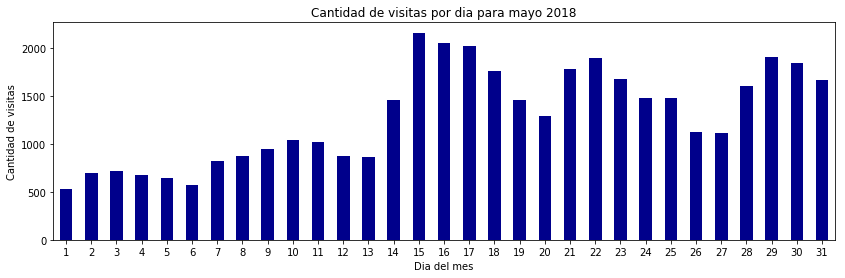

In [16]:
visitas_mayo_2018 = visitas.loc[visitas['fecha'].dt.month  == 5,['event','fecha']]
visitas_mayo_2018['dia'] = visitas_mayo_2018['fecha'].dt.day
#eventos_por_dia_mayo = visitas_mayo_2018.groupby(['dia']).agg('count')
eventos_por_dia_mayo = visitas_mayo_2018.groupby(['dia']).count().reset_index()
eventos_por_dia_mayo.set_index('dia', inplace=True)
eventos_por_dia_mayo.rename({'event' : 'cantidad de visitas','0':'count'}, axis=1, inplace=True)
eventos_por_dia_mayo_plot = eventos_por_dia_mayo.plot(rot=0, y= 'cantidad de visitas', title = "Cantidad de visitas por dia para mayo 2018", kind='bar',figsize=(14,4), color = 'darkblue')
eventos_por_dia_mayo_plot.set_ylabel('Cantidad de visitas')
eventos_por_dia_mayo_plot.set_xlabel('Dia del mes')
eventos_por_dia_mayo_plot.legend().set_visible(False)
plt.show()

### Perfiles predominantes de los usuarios

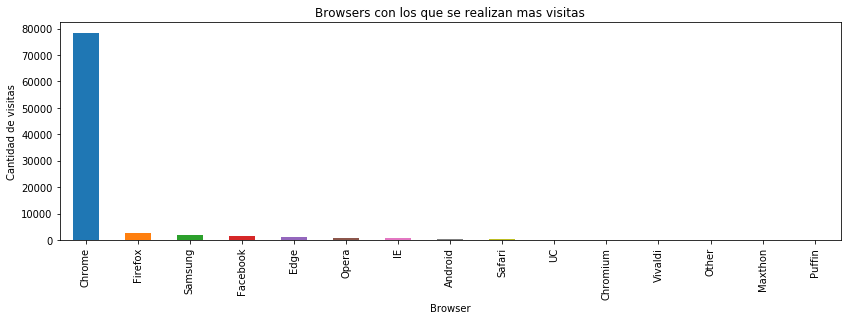

In [17]:
browsers = visitas.loc[:, ['event','browser_version']]
browsers = browsers.groupby('browser_version').size().reset_index()
browsers.rename({
    0:'count'
}, axis=1, inplace=True)
browsers.sort_values(by='count', ascending=False, inplace=True)

plot_browsers = browsers.head(15)
plot_browsers = plot_browsers.plot(x='browser_version', y='count', title = "Browsers con los que se realizan mas visitas",kind='bar',figsize=(14,4))
plot_browsers.set_ylabel('Cantidad de visitas')
plot_browsers.set_xlabel('Browser')
plot_browsers.legend().set_visible(False)
plt.show()

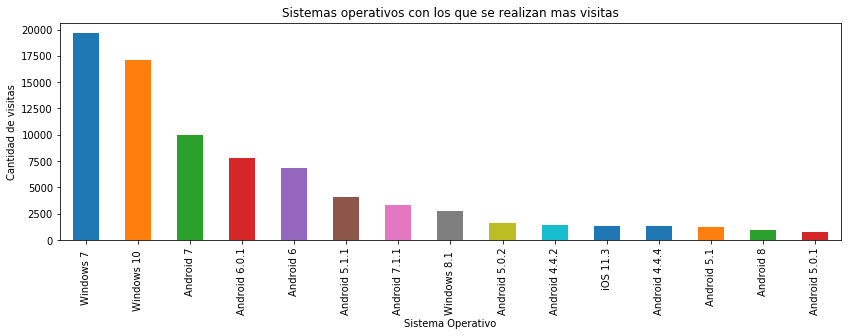

In [18]:
systems = visitas.loc[:, ['event','operating_system_version']]
systems= systems.groupby('operating_system_version').size().reset_index()
systems.rename({
    0:'count'
}, axis=1, inplace=True)
systems.sort_values(by='count', ascending=False, inplace=True)

plot_systems = systems.head(15)
plot_systems = plot_systems.plot(x='operating_system_version', y='count', title = "Sistemas operativos con los que se realizan mas visitas",kind='bar',figsize=(14,4))
plot_systems.set_ylabel('Cantidad de visitas')
plot_systems.set_xlabel('Sistema Operativo')
plot_systems.legend().set_visible(False)
plt.show()

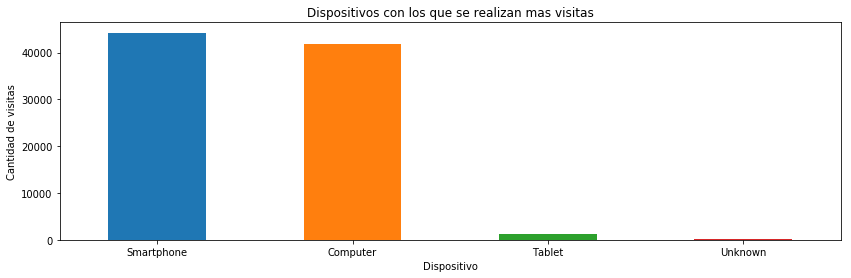

In [19]:
devices = visitas.loc[:, ['event','device_type']]
devices= devices.groupby('device_type').size().reset_index()
devices.rename({
    0:'count'
}, axis=1, inplace=True)
devices.sort_values(by='count', ascending=False, inplace=True)

plot_devices = devices.plot(x='device_type', y='count', title = "Dispositivos con los que se realizan mas visitas",kind='bar',figsize=(14,4), rot=0)
plot_devices.set_ylabel('Cantidad de visitas')
plot_devices.set_xlabel('Dispositivo')
plot_devices.legend().set_visible(False)
plt.show()

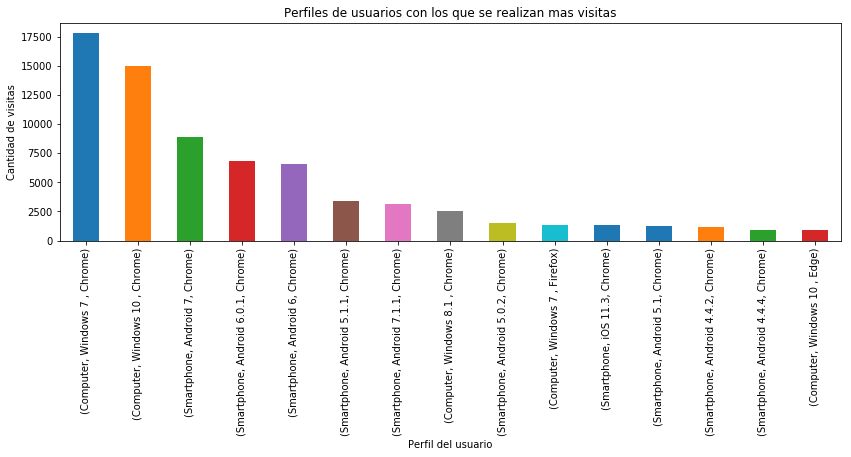

In [20]:
perfil = visitas.loc[:, ['event','device_type','operating_system_version','browser_version']]
perfil= perfil.groupby(['device_type','operating_system_version','browser_version']).size().reset_index()
perfil.rename({
    0:'count'
}, axis=1, inplace=True)
perfil.sort_values(by='count', ascending=False, inplace=True)

plot_perfil = perfil.head(15)
plot_perfil = plot_perfil.plot(x=['device_type','operating_system_version','browser_version'], y='count', title = "Perfiles de usuarios con los que se realizan mas visitas",kind='bar',figsize=(14,4))
plot_perfil.set_ylabel('Cantidad de visitas')
plot_perfil.set_xlabel('Perfil del usuario')
plot_perfil.legend().set_visible(False)
plt.show()

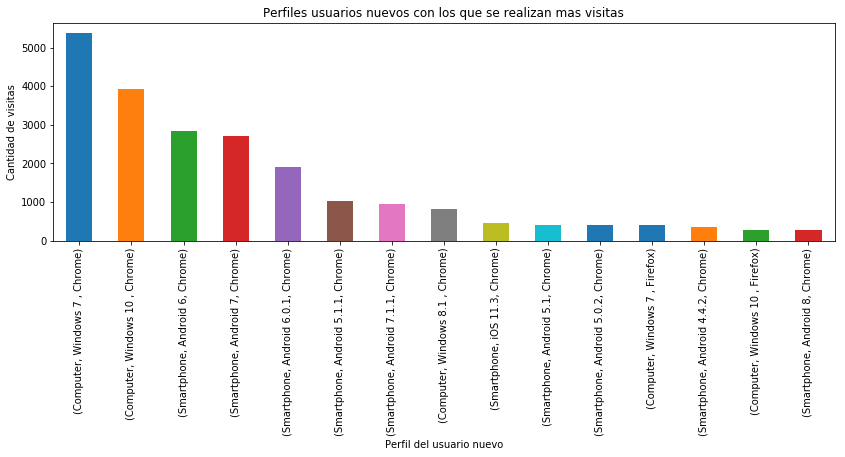

In [21]:
perfil_estado = visitas.loc[:, ['event','device_type','operating_system_version','browser_version','new_vs_returning']]
perfil_new = perfil_estado.loc[perfil_estado.new_vs_returning == 'New']
perfil_new= perfil_new.groupby(['device_type','operating_system_version','browser_version']).size().reset_index()
perfil_new.rename({
    0:'count'
}, axis=1, inplace=True)
perfil_new.sort_values(by='count', ascending=False, inplace=True)

plot_perfil_new = perfil_new.head(15)
plot_perfil_new = plot_perfil_new.plot(x=['device_type','operating_system_version','browser_version'], y='count', title = "Perfiles usuarios nuevos con los que se realizan mas visitas",kind='bar',figsize=(14,4))
plot_perfil_new.set_ylabel('Cantidad de visitas')
plot_perfil_new.set_xlabel('Perfil del usuario nuevo')
plot_perfil_new.legend().set_visible(False)
plt.show()

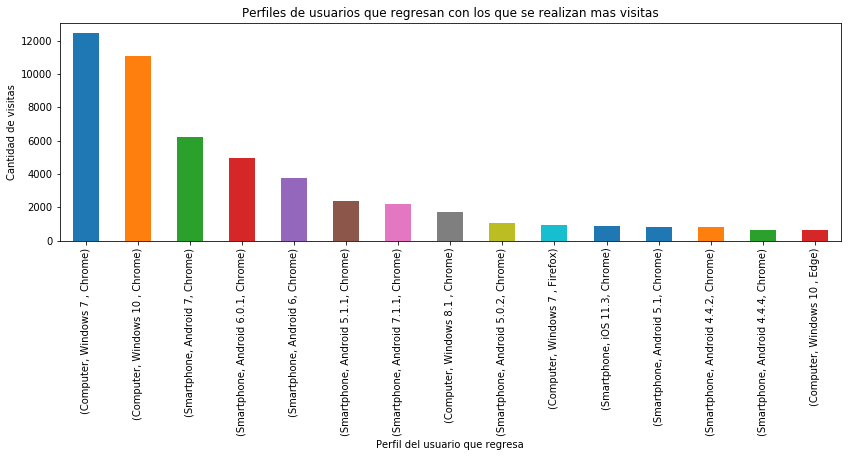

In [22]:
perfil_returning = perfil_estado.loc[perfil_estado.new_vs_returning == 'Returning']
perfil_returning= perfil_returning.groupby(['device_type','operating_system_version','browser_version']).size().reset_index()
perfil_returning.rename({
    0:'count'
}, axis=1, inplace=True)
perfil_returning.sort_values(by='count', ascending=False, inplace=True)

plot_perfil_returning = perfil_returning.head(15)
plot_perfil_returning = plot_perfil_returning.plot(x=['device_type','operating_system_version','browser_version'], y='count', title = "Perfiles de usuarios que regresan con los que se realizan mas visitas",kind='bar',figsize=(14,4))
plot_perfil_returning.set_ylabel('Cantidad de visitas')
plot_perfil_returning.set_xlabel('Perfil del usuario que regresa')
plot_perfil_returning.legend().set_visible(False)
plt.show()

# Analisis de eventos de productos

In [23]:
#Los eventos de productos son las rows donde existe "sku" (id del producto)
eventos_productos = events.loc[:, ['event','fecha','person','sku', 'model', 'condition', 'storage', 'color']]
eventos_productos = eventos_productos.loc[eventos_productos.sku.notnull()]
eventos_productos_distintos = eventos_productos.groupby('event').count()
eventos_productos_distintos.head()
#Por lo tanto, son 3 eventos de productos: viewed product, checkout y conversion

,fecha,person,sku,model,condition,storage,color
event,,,,,,,
checkout,33735,33735,33735,33733,33733,33733,33733
conversion,1172,1172,1172,1172,1172,1172,1172
viewed product,528931,528931,528931,528931,528931,528931,528931


### Relacion de eventos de productos por dia y hora de la semana

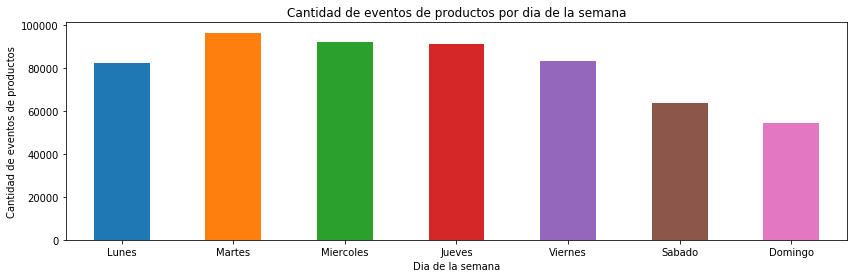

In [24]:
eventos_productos_dias = eventos_productos.loc[:,['event','fecha']]

eventos_productos_dias['weekday'] = eventos_productos_dias['fecha'].dt.weekday_name
eventos_productos_dias['dayofweek'] = eventos_productos_dias['fecha'].dt.dayofweek
eventos_productos_dias_groupby = eventos_productos_dias.groupby(['dayofweek','weekday']).count()['fecha'].reset_index()
eventos_productos_dias_groupby.set_index('weekday', inplace=True)
eventos_productos_dias_groupby.drop('dayofweek', inplace=True, axis=1)
eventos_productos_dias_groupby.index.name = None
eventos_productos_dias_groupby.rename({
    'Monday' : 'Lunes',
    'Tuesday' : 'Martes',
    'Wednesday' : 'Miercoles',
    'Thursday' : 'Jueves',
    'Friday' : 'Viernes',
    'Saturday' : 'Sabado',
    'Sunday' : 'Domingo'
}, axis=0, inplace=True)

plot_eventos_productos_dias = eventos_productos_dias_groupby.plot(y='fecha', title = "Cantidad de eventos de productos por dia de la semana",kind='bar',figsize=(14,4), rot=0)
plot_eventos_productos_dias.set_ylabel('Cantidad de eventos de productos')
plot_eventos_productos_dias.set_xlabel('Dia de la semana')
plot_eventos_productos_dias.legend().set_visible(False)
plt.show()

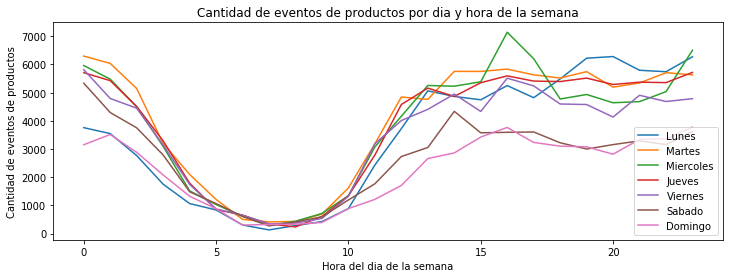

In [25]:
eventos_productos_dyh = eventos_productos_dias

eventos_productos_dyh['hour'] = eventos_productos_dyh['fecha'].dt.hour
eventos_productos_dyh = eventos_productos_dyh.loc[:,['event','weekday','hour']]

#separo por dia
lunes = eventos_productos_dyh[eventos_productos_dyh.weekday == 'Monday']
martes = eventos_productos_dyh[eventos_productos_dyh.weekday == 'Tuesday']
miercoles = eventos_productos_dyh[eventos_productos_dyh.weekday == 'Wednesday']
jueves = eventos_productos_dyh[eventos_productos_dyh.weekday == 'Thursday']
viernes = eventos_productos_dyh[eventos_productos_dyh.weekday == 'Friday']
sabado = eventos_productos_dyh[eventos_productos_dyh.weekday == 'Saturday']
domingo = eventos_productos_dyh[eventos_productos_dyh.weekday == 'Sunday']

#agrupo por hora por cada dia con la cantidad de postulaciones
lunes = lunes.groupby('hour', as_index=False)['event'].count()
lunes.columns = ['hour', 'Lunes']
martes = martes.groupby('hour', as_index=False)['event'].count()
martes.columns = ['hour', 'Martes']
miercoles = miercoles.groupby('hour', as_index=False)['event'].count()
miercoles.columns = ['hour', 'Miercoles']
jueves = jueves.groupby('hour', as_index=False)['event'].count()
jueves.columns = ['hour', 'Jueves']
viernes = viernes.groupby('hour', as_index=False)['event'].count()
viernes.columns = ['hour', 'Viernes']
sabado = sabado.groupby('hour', as_index=False)['event'].count()
sabado.columns = ['hour', 'Sabado']
domingo = domingo.groupby('hour', as_index=False)['event'].count()
domingo.columns = ['hour', 'Domingo']

#junto los dias
eventos_productos_dyh = pd.merge(lunes, martes, on='hour', how="left")
eventos_productos_dyh = pd.merge(eventos_productos_dyh, miercoles, on='hour', how="left")
eventos_productos_dyh = pd.merge(eventos_productos_dyh, jueves, on='hour', how="left")
eventos_productos_dyh = pd.merge(eventos_productos_dyh, viernes, on='hour', how="left")
eventos_productos_dyh = pd.merge(eventos_productos_dyh, sabado, on='hour', how="left")
eventos_productos_dyh = pd.merge(eventos_productos_dyh, domingo, on='hour', how="left")

eventos_productos_dyh = eventos_productos_dyh.plot(x='hour', title="Cantidad de eventos de productos por dia y hora de la semana", figsize=(12,4))
eventos_productos_dyh.set_ylabel('Cantidad de eventos de productos')
eventos_productos_dyh.set_xlabel('Hora del dia de la semana')
plt.show()

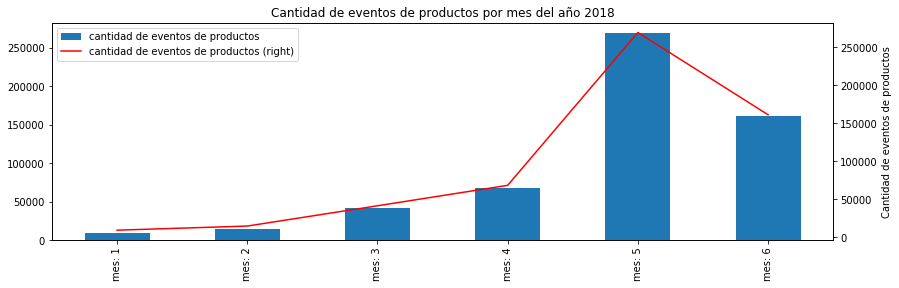

In [26]:
#Por meses del anio 2018
eventos_productos_anio = eventos_productos.loc[:,['event', 'fecha']]
eventos_productos_anio = eventos_productos_anio.loc[eventos_productos_anio['fecha'].dt.year  == 2018]
eventos_productos_anio['fecha'] = "mes: " + eventos_productos_anio['fecha'].dt.month.astype(str)
eventos_productos_anio_groupby = eventos_productos_anio.groupby('fecha').count().reset_index()
eventos_productos_anio_groupby.rename({'event' : 'cantidad de eventos de productos'}, axis=1, inplace=True)
eventos_productos_anio_groupby.set_index('fecha', inplace=True)
eventos_productos_anio_groupby.index.name = None

ax = plt.gca()

eventos_productos_anio_groupby.plot(rot=90, ax = ax, title = "Cantidad de eventos de productos por mes del año 2018", kind='bar',figsize=(14,4))
eventos_productos_anio_groupby.plot(rot=90, ax = ax, title = "Cantidad de eventos de productos por mes del año 2018", kind='line',figsize=(14,4), secondary_y=True, color='red')
plt.xlabel('Dia de la semana')
plt.ylabel('Cantidad de eventos de productos');

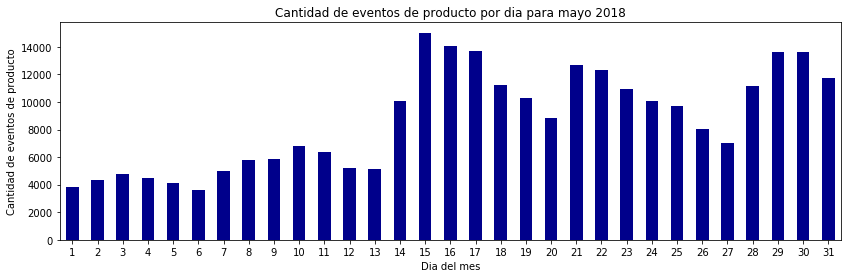

In [27]:
eventos_productos_mayo_2018 = eventos_productos.loc[eventos_productos['fecha'].dt.month  == 5,['event','fecha']]
eventos_productos_mayo_2018['dia'] = eventos_productos_mayo_2018['fecha'].dt.day
eventos_productos_mayo_2018_por_dia = eventos_productos_mayo_2018.groupby(['dia']).count().reset_index()
eventos_productos_mayo_2018_por_dia.set_index('dia', inplace=True)
eventos_productos_mayo_2018_por_dia.rename({'event' : 'cantidad de eventos de producto','0':'count'}, axis=1, inplace=True)
plot = eventos_productos_mayo_2018_por_dia.plot(rot=0, y= 'cantidad de eventos de producto', title = "Cantidad de eventos de producto por dia para mayo 2018", kind='bar',figsize=(14,4), color = 'darkblue')
plot.set_ylabel('Cantidad de eventos de producto')
plot.set_xlabel('Dia del mes')
plot.legend().set_visible(False)
plt.show()

### Productos Predominantes

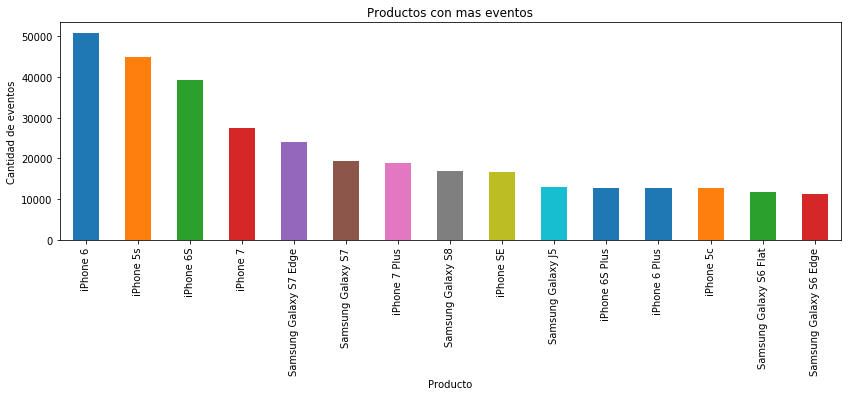

In [28]:
productos = eventos_productos.loc[:, ['event','model']]
productos = productos.groupby('model').size().reset_index()
productos.rename({
    0:'count'
}, axis=1, inplace=True)
productos.sort_values(by='count', ascending=False, inplace=True)

plot_productos = productos.head(15)
plot_productos = plot_productos.plot(x='model', y='count', title = "Productos con mas eventos",kind='bar',figsize=(14,4))
plot_productos.set_ylabel('Cantidad de eventos')
plot_productos.set_xlabel('Producto')
plot_productos.legend().set_visible(False)
plt.show()

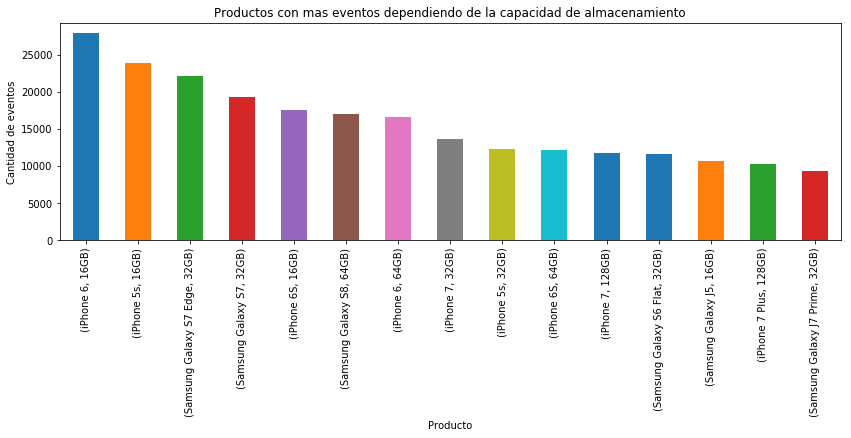

In [29]:
productos_storage = eventos_productos.loc[:, ['event','model','storage']]
productos_storage = productos_storage.groupby(['model','storage']).size().reset_index()
productos_storage.rename({
    0:'count'
}, axis=1, inplace=True)
productos_storage.sort_values(by='count', ascending=False, inplace=True)

plot_productos_storage = productos_storage.head(15)
plot_productos_storage = plot_productos_storage.plot(x=['model','storage'], y='count', title = "Productos con mas eventos dependiendo de la capacidad de almacenamiento",kind='bar',figsize=(14,4))
plot_productos_storage.set_ylabel('Cantidad de eventos')
plot_productos_storage.set_xlabel('Producto')
plot_productos_storage.legend().set_visible(False)
plt.show()

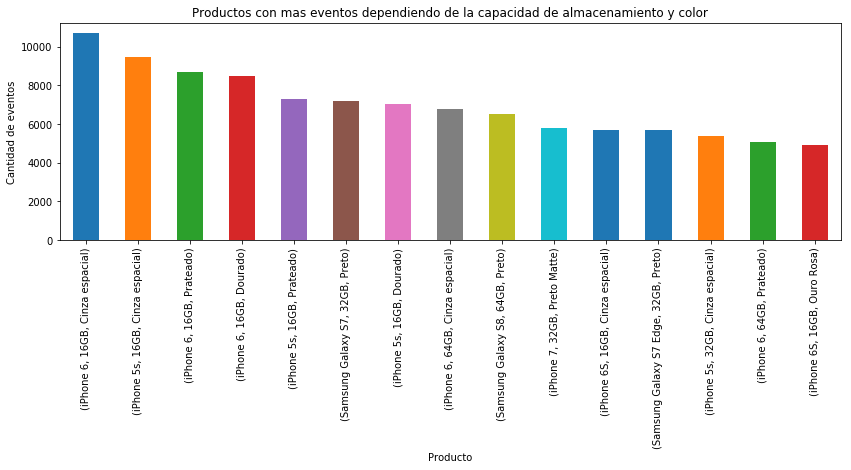

In [30]:
productos_caracteristicas = eventos_productos.loc[:, ['event','model','storage','color']]
productos_caracteristicas = productos_caracteristicas.groupby(['model','storage','color']).size().reset_index()
productos_caracteristicas.rename({
    0:'count'
}, axis=1, inplace=True)
productos_caracteristicas.sort_values(by='count', ascending=False, inplace=True)

plot_productos_caracteristicas = productos_caracteristicas.head(15)
plot_productos_caracteristicas = plot_productos_caracteristicas.plot(x=['model','storage','color'], y='count', title = "Productos con mas eventos dependiendo de la capacidad de almacenamiento y color",kind='bar',figsize=(14,4))
plot_productos_caracteristicas.set_ylabel('Cantidad de eventos')
plot_productos_caracteristicas.set_xlabel('Producto')
plot_productos_caracteristicas.legend().set_visible(False)
plt.show()

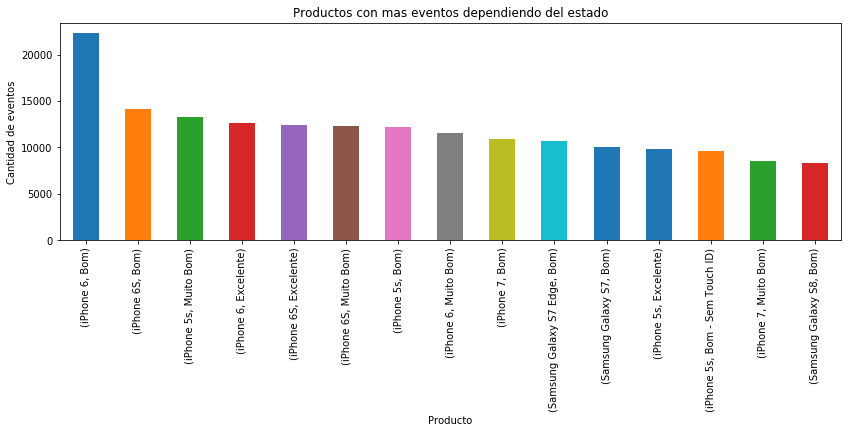

In [31]:
productos_condition = eventos_productos.loc[:, ['event','model','condition']]
productos_condition = productos_condition.groupby(['model','condition']).size().reset_index()
productos_condition.rename({
    0:'count'
}, axis=1, inplace=True)
productos_condition.sort_values(by='count', ascending=False, inplace=True)

plot_productos_condition = productos_condition.head(15)
plot_productos_condition = plot_productos_condition.plot(x=['model','condition'], y='count', title = "Productos con mas eventos dependiendo del estado",kind='bar',figsize=(14,4))
plot_productos_condition.set_ylabel('Cantidad de eventos')
plot_productos_condition.set_xlabel('Producto')
plot_productos_condition.legend().set_visible(False)
plt.show()

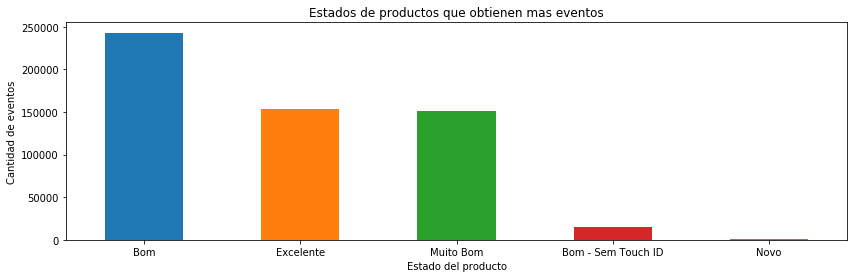

In [32]:
eventos_estado = eventos_productos.loc[:, ['event','condition']]
eventos_estado = eventos_estado.groupby('condition').size().reset_index()
eventos_estado.rename({
    0:'count'
}, axis=1, inplace=True)
eventos_estado.sort_values(by='count', ascending=False, inplace=True)

plot_eventos_estado = eventos_estado.plot(x='condition', y='count', title = "Estados de productos que obtienen mas eventos",kind='bar',figsize=(14,4), rot=0)
plot_eventos_estado.set_ylabel('Cantidad de eventos')
plot_eventos_estado.set_xlabel('Estado del producto')
plot_eventos_estado.legend().set_visible(False)
plt.show()

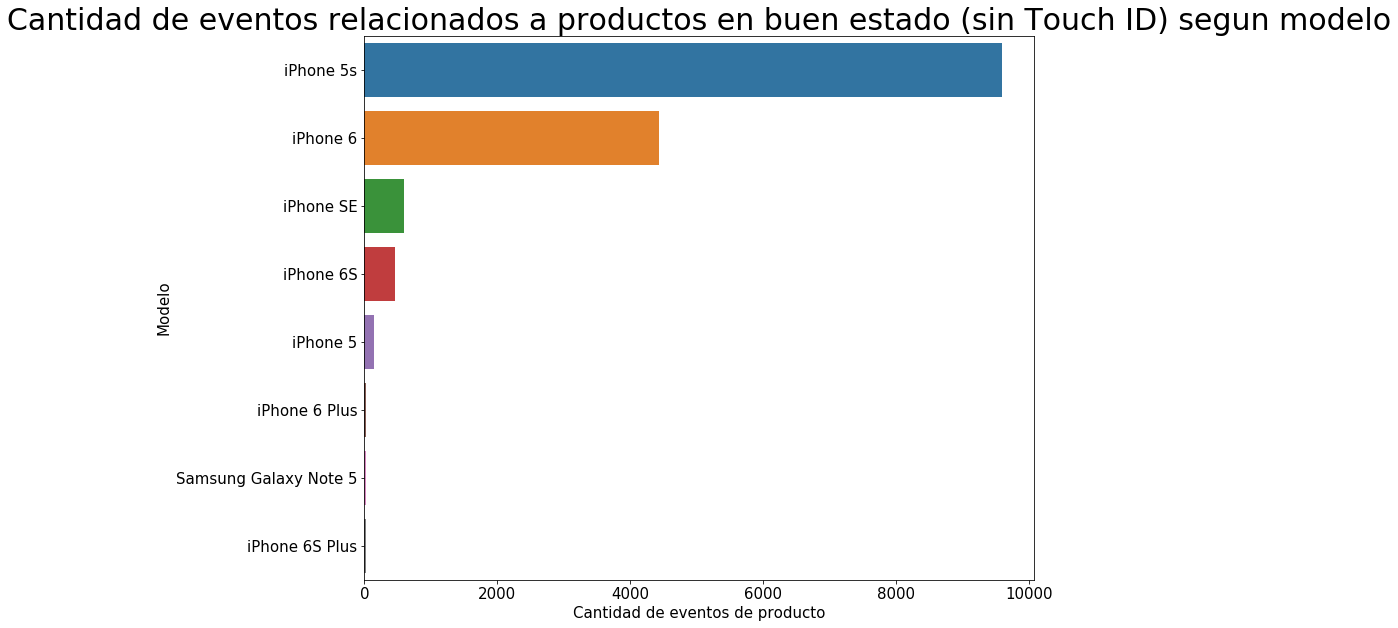

In [33]:
#Analisis de estado Bom - Sem Touch ID
events_sem = eventos_productos.loc[events['condition'] == 'Bom - Sem Touch ID']
events_sem_count = events_sem['model'].value_counts()
plt.figure(figsize = [12,10])
visu = sns.barplot(x=events_sem_count.values, y=events_sem_count.index, orient='h')
plt.xlabel("Cantidad de eventos de producto", fontsize=15)
plt.ylabel("Modelo", fontsize=15)
plt.title("Cantidad de eventos relacionados a productos en buen estado (sin Touch ID) segun modelo", fontsize=30)
plt.tick_params(labelsize=15)
plt.show(visu)

# Analisis de Paises/Regiones con mas eventos realizados

In [34]:
paises_regiones_predom = visitas.loc[:,['event','country','region']]
paises_regiones_predom = paises_regiones_predom.loc[(paises_regiones_predom.country != 'Unknown') & (paises_regiones_predom.region != 'Unknown')]
paises_regiones_predom = paises_regiones_predom.groupby(['country','region']).count()['event'].reset_index()
paises_regiones_predom.rename({
    'event':'count'
}, axis=1, inplace=True)
paises_regiones_predom = paises_regiones_predom.loc[paises_regiones_predom['count'] >= 49]
paises_regiones_predom.sort_values(by='count', ascending=False, inplace=True)
paises_regiones_predom.head(31)

,country,region,count
31,Brazil,Sao Paulo,24996
19,Brazil,Minas Gerais,7755
27,Brazil,Rio de Janeiro,6913
11,Brazil,Bahia,5737
23,Brazil,Pernambuco,2962
12,Brazil,Ceara,2829
21,Brazil,Parana,2602
26,Brazil,Rio Grande do Sul,2576
14,Brazil,Federal District,1739
15,Brazil,Goias,1564


In [35]:
lat_long = [{'country': 'Brazil', 'region': 'Sao Paulo', 'latitud': -23.5475000, 'longitud': -46.6361100},
            {'country': 'Brazil', 'region': 'Minas Gerais', 'latitud': -17.930178, 'longitud': -43.790844},
            {'country': 'Brazil', 'region': 'Rio de Janeiro', 'latitud': -22.902780, 'longitud': -43.207500}, 
            {'country': 'Brazil', 'region': 'Bahia', 'latitud': -12.971110, 'longitud': -38.510830},
            {'country': 'Brazil', 'region': 'Pernambuco', 'latitud': -8.053890, 'longitud': -34.881110},
            {'country': 'Brazil', 'region': 'Ceara', 'latitud':  -3.764103, 'longitud': -38.607983},
            {'country': 'Brazil', 'region': 'Parana', 'latitud': -24.5, 'longitud': -51.33333},
            {'country': 'Brazil', 'region': 'Rio Grande do Sul', 'latitud': -30, 'longitud': -53.5},
            {'country': 'Brazil', 'region': 'Federal District', 'latitud': -15.75 , 'longitud': -47.75},
            {'country': 'Brazil', 'region': 'Goias', 'latitud': -15.80277, 'longitud': -50.24132},
            {'country': 'Brazil', 'region': 'Santa Catarina', 'latitud': -27, 'longitud': -50},
            {'country': 'Brazil', 'region': 'Para', 'latitud': -4, 'longitud': -53},
            {'country': 'Brazil', 'region': 'Maranhao', 'latitud': -5, 'longitud': -45},
            {'country': 'Brazil', 'region': 'Espirito Santo', 'latitud': -20, 'longitud': -40.75},
            {'country': 'Brazil', 'region': 'Rio Grande do Norte', 'latitud': -5.75, 'longitud': -36.5},
            {'country': 'Brazil', 'region': 'Paraíba', 'latitud': -7.25, 'longitud': -36.5},
            {'country': 'Brazil', 'region': 'Piaui', 'latitud': -7.25, 'longitud': -42.33333},
            {'country': 'Brazil', 'region': 'Alagoas', 'latitud': -9.58333, 'longitud': -36.41667},
            {'country': 'Brazil', 'region': 'Mato Grosso do Sul', 'latitud': -20.5, 'longitud': -55},
            {'country': 'Brazil', 'region': 'Amazonas', 'latitud': -3.75, 'longitud': -64.5},
            {'country': 'Brazil', 'region': 'Tocantins', 'latitud': -10.5, 'longitud': -48},
            {'country': 'Brazil', 'region': 'Mato Grosso', 'latitud': -13, 'longitud': -56},
            {'country': 'Brazil', 'region': 'Sergipe', 'latitud': -10.5, 'longitud': -37.33333},
            {'country': 'Brazil', 'region': 'Rondonia', 'latitud': -11, 'longitud': -63},
            {'country': 'United States', 'region': 'California', 'latitud': 37.25022, 'longitud': -119.75126},
            {'country': 'Brazil', 'region': 'Amapa', 'latitud': 1, 'longitud': -52},
            {'country': 'United States', 'region': 'New York', 'latitud': 40.71427, 'longitud': -74.00597},
            {'country': 'Brazil', 'region': 'Acre', 'latitud': -9, 'longitud': -70},
            {'country': 'Argentina', 'region': 'Buenos Aires F.D.', 'latitud': -34.6, 'longitud': -58.45},
            {'country': 'Brazil', 'region': 'Roraima', 'latitud':  2.25, 'longitud': -61.25},
            {'country': 'United States', 'region': 'Michigan', 'latitud': 44.25029, 'longitud': -85.50033}]
lat_long = pd.DataFrame(lat_long)
paises_regiones_lat_long = paises_regiones_predom.merge(lat_long, on=['country','region'], how='inner')
paises_regiones_lat_long.head(31)

,country,region,count,latitud,longitud
0,Brazil,Sao Paulo,24996,-23.547500,-46.636110
1,Brazil,Minas Gerais,7755,-17.930178,-43.790844
2,Brazil,Rio de Janeiro,6913,-22.902780,-43.207500
3,Brazil,Bahia,5737,-12.971110,-38.510830
4,Brazil,Pernambuco,2962,-8.053890,-34.881110
5,Brazil,Ceara,2829,-3.764103,-38.607983
6,Brazil,Parana,2602,-24.500000,-51.333330
7,Brazil,Rio Grande do Sul,2576,-30.000000,-53.500000
8,Brazil,Federal District,1739,-15.750000,-47.750000
9,Brazil,Goias,1564,-15.802770,-50.241320


In [36]:
def generar_archivo_kml(nombre):
    archivo = open(nombre, "w")
    archivo.write('<?xml version="1.0" encoding="UTF-8"?>\n')
    archivo.write('<kml xmlns="http://earth.google.com/kml/2.1">\n')
    archivo.write("\t<Document>\n")
    archivo.write("\t\t<name>" + nombre + "</name>\n")
    archivo.write("\n")
    archivo.close()
    
def agregar_pais_region(archivo, pais, region, coordenadas):
    archivo = open(archivo, "a")
    archivo.write("\t\t<Placemark>\n")
    archivo.write("\t\t\t<name>" + pais + "</name>\n")
    archivo.write("\t\t\t<region>" + region + "</region>\n")
    archivo.write("\t\t\t<Point>\n")
    archivo.write("\t\t\t\t<coordinates>" + coordenadas + "</coordinates>\n")
    archivo.write("\t\t\t</Point>\n")
    archivo.write("\t\t</Placemark>\n")
    archivo.write("\n")

def cerrar_archivo_kml(nombre):
    archivo = open(nombre, "a")
    archivo.write("\t</Document>\n")
    archivo.write("</kml>")
    archivo.close()

generar_archivo_kml('paises_regiones_con_mas_eventos.kml')
for i in range(31):
    agregar_pais_region('paises_regiones_con_mas_eventos.kml',str(paises_regiones_lat_long['country'][i]), str(paises_regiones_lat_long['region'][i]),str(paises_regiones_lat_long['longitud'][i])+','+str(paises_regiones_lat_long['latitud'][i]))
cerrar_archivo_kml('paises_regiones_con_mas_eventos.kml')

# Paises/Regiones con mas eventos realizados

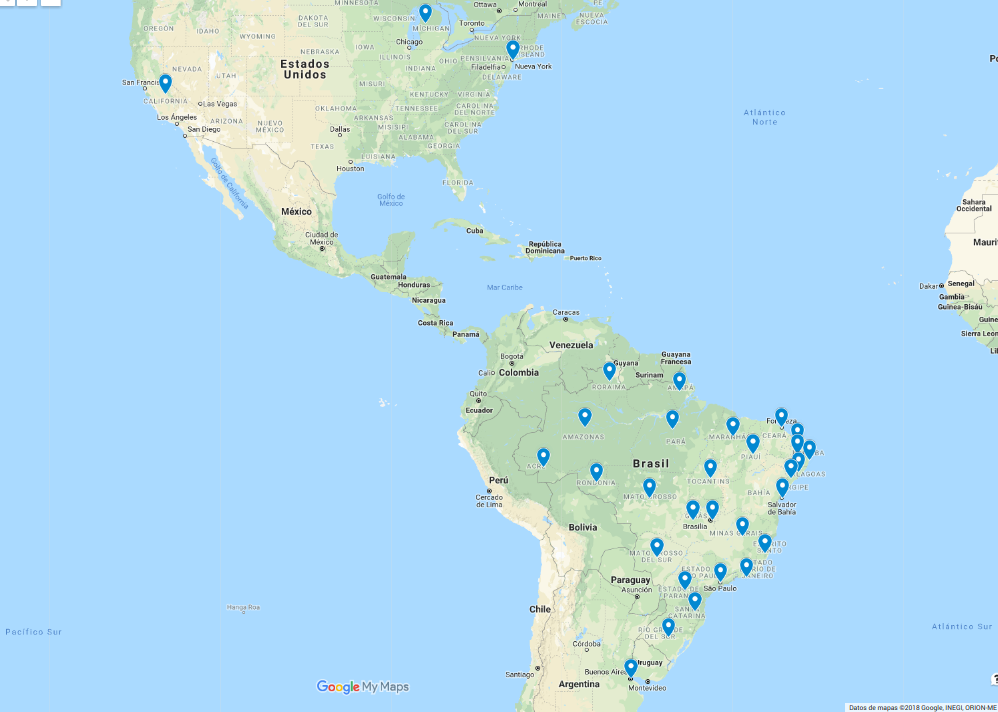

In [37]:
Image("paises_regiones_con_mas_eventos.png")

# Analisis de Paises/Regiones con pocos eventos realizados

In [38]:
paises_regiones_infimos = visitas.loc[:,['event','country','region']]
paises_regiones_infimos = paises_regiones_infimos.loc[(paises_regiones_infimos.country != 'Unknown') & (paises_regiones_infimos.region != 'Unknown')]
paises_regiones_infimos = paises_regiones_infimos.groupby(['country','region']).count()['event'].reset_index()
paises_regiones_infimos.rename({
    'event':'count'
}, axis=1, inplace=True)
paises_regiones_infimos = paises_regiones_infimos.loc[(paises_regiones_infimos['count'] > 1) & (paises_regiones_infimos['count'] < 49)]
paises_regiones_infimos.sort_values(by='count', ascending=True, inplace=True)
paises_regiones_infimos.head(32)

,country,region,count
2,Argentina,Cordoba,2
43,Germany,Hesse,2
44,India,Maharashtra,2
52,Paraguay,Asuncion,2
55,Portugal,Porto,3
83,United States,Nevada,3
82,United States,Missouri,3
41,France,Lorraine,3
46,Italy,Province of Arezzo,3
65,Switzerland,Basel-City,3


In [39]:
lat_long_inf = [{'country': 'Argentina', 'region': 'Cordoba', 'latitud': -31.4135, 'longitud': -64.18105},
            {'country': 'Germany', 'region': 'Hesse', 'latitud': 50.55, 'longitud': 9},
            {'country': 'India', 'region': 'Maharashtra', 'latitud': 19.5, 'longitud': 76}, 
            {'country': 'Paraguay', 'region': 'Asuncion', 'latitud': -25.30066, 'longitud': -57.63591},
            {'country': 'United States', 'region': 'Nevada', 'latitud': 39.25021, 'longitud': -116.75119},
            {'country': 'United States', 'region': 'Missouri', 'latitud':  38.25031, 'longitud': -92.50046},
            {'country': 'France', 'region': 'Lorraine', 'latitud': 36.2833333, 'longitud': 29.9833334},
            {'country': 'Italy', 'region': 'Province of Arezzo', 'latitud': 43.53333, 'longitud': 11.83333},
            {'country': 'Switzerland', 'region': 'Basel-City', 'latitud': 47.5438216 , 'longitud': 7.6184677},
            {'country': 'Portugal', 'region': 'Porto', 'latitud': 41.14961, 'longitud': -8.61099},
            {'country': 'United States', 'region': 'Pennsylvania', 'latitud': 40.27245, 'longitud': -76.90567},
            {'country': 'Argentina', 'region': 'Buenos Aires', 'latitud': -34.6075615, 'longitud': -58.4370759},
            {'country': 'United States', 'region': 'Minnesota', 'latitud': 46.25024, 'longitud': -94.25055},
            {'country': 'United States', 'region': 'Florida', 'latitud': 28.75054, 'longitud': -82.5001},
            {'country': 'United Kingdom', 'region': 'Wrexham', 'latitud': 53.04664, 'longitud': -2.99132},
            {'country': 'United Kingdom', 'region': 'England', 'latitud': 52.16045, 'longitud': -0.70312},
            {'country': 'Romania', 'region': 'Vaslui', 'latitud': 46.63333, 'longitud': 27.73333},
            {'country': 'Dominican Republic', 'region': 'Nacional', 'latitud': 18.50012, 'longitud': -69.98857},
            {'country': 'Canada', 'region': 'British Columbia', 'latitud': 53.99983, 'longitud': -125.0032 },
            {'country': 'United States', 'region': 'Washington', 'latitud': 38.89511, 'longitud': -77.03637},
            {'country': 'Mozambique', 'region': 'Cidade de Maputo', 'latitud': -25.96528, 'longitud': 32.58917},
            {'country': 'Poland', 'region': 'Łódź Voivodeship', 'latitud': 51.7687323, 'longitud': 19.4569911},
            {'country': 'Netherlands', 'region': 'North Holland', 'latitud': 52.58333, 'longitud': 4.91667},
            {'country': 'United States', 'region': 'Illinois', 'latitud': 40.00032, 'longitud': -89.25037},
            {'country': 'Canada', 'region': 'Ontario', 'latitud': 49.25014, 'longitud': -84.49983},
            {'country': 'United States', 'region': 'Colorado', 'latitud': 39.00027, 'longitud': -105.50083},
            {'country': 'United States', 'region': 'Connecticut', 'latitud': 41.66704, 'longitud': -72.66648},
            {'country': 'Japan', 'region': 'Aichi', 'latitud': 35.18017, 'longitud': 136.90656},
            {'country': 'United States', 'region': 'Tennessee', 'latitud': 40.41199, 'longitud': -90.8393},
            {'country': 'Canada', 'region': 'Quebec', 'latitud': 52.00017, 'longitud': -71.99907},
            {'country': 'United States', 'region': 'Texas', 'latitud': 31.25044, 'longitud': -99.25061},
            {'country': 'United States', 'region': 'New Jersey', 'latitud': 40.16706, 'longitud': -74.49987}]
lat_long_inf = pd.DataFrame(lat_long_inf)
paises_regiones_lat_long_inf = paises_regiones_infimos.merge(lat_long_inf, on=['country','region'], how='inner')
paises_regiones_lat_long_inf.head(32)

,country,region,count,latitud,longitud
0,Argentina,Cordoba,2,-31.413500,-64.181050
1,Germany,Hesse,2,50.550000,9.000000
2,India,Maharashtra,2,19.500000,76.000000
3,Paraguay,Asuncion,2,-25.300660,-57.635910
4,Portugal,Porto,3,41.149610,-8.610990
5,United States,Nevada,3,39.250210,-116.751190
6,United States,Missouri,3,38.250310,-92.500460
7,France,Lorraine,3,36.283333,29.983333
8,Italy,Province of Arezzo,3,43.533330,11.833330
9,Switzerland,Basel-City,3,47.543822,7.618468


In [40]:
generar_archivo_kml('paises_regiones_con_pocos_eventos.kml')
for i in range(32):
    agregar_pais_region('paises_regiones_con_pocos_eventos.kml',str(paises_regiones_lat_long_inf['country'][i]), str(paises_regiones_lat_long_inf['region'][i]),str(paises_regiones_lat_long_inf['longitud'][i])+','+str(paises_regiones_lat_long_inf['latitud'][i]))
cerrar_archivo_kml('paises_regiones_con_pocos_eventos.kml')

# Paises/Regiones con pocos eventos realizados

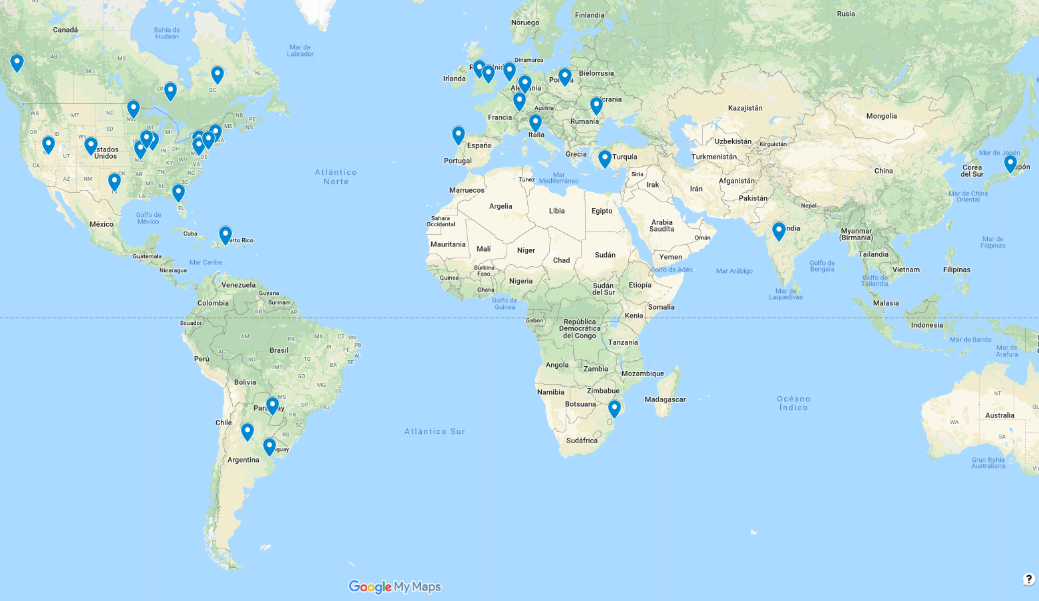

In [41]:
Image("paises_regiones_con_pocos_eventos.png")

# Analisis de eventos realizados por usuarios nuevos y regresantes

In [42]:
usuario_nuevos = visitas.loc[visitas.new_vs_returning == 'New']
usuario_nuevos = usuario_nuevos.loc[:,['event', 'person']]
usuario_nuevos = usuario_nuevos.groupby('person').count()['event'].reset_index()
usuario_nuevos.rename({'event':'cant_eventos_new'}, axis=1, inplace=True)
usuario_nuevos.describe()

,cant_eventos_new
count,26898.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0


In [43]:
usuario_regresantes = visitas.loc[visitas.new_vs_returning == 'Returning']
usuario_regresantes = usuario_regresantes.loc[:,['event', 'person']]
usuario_regresantes = usuario_regresantes.groupby('person').count()['event'].reset_index()
usuario_regresantes.rename({'event':'cant_eventos_returning'}, axis=1, inplace=True)
usuario_regresantes.describe()

,cant_eventos_returning
count,11131.000000
mean,5.433474
std,9.963363
min,1.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,262.000000


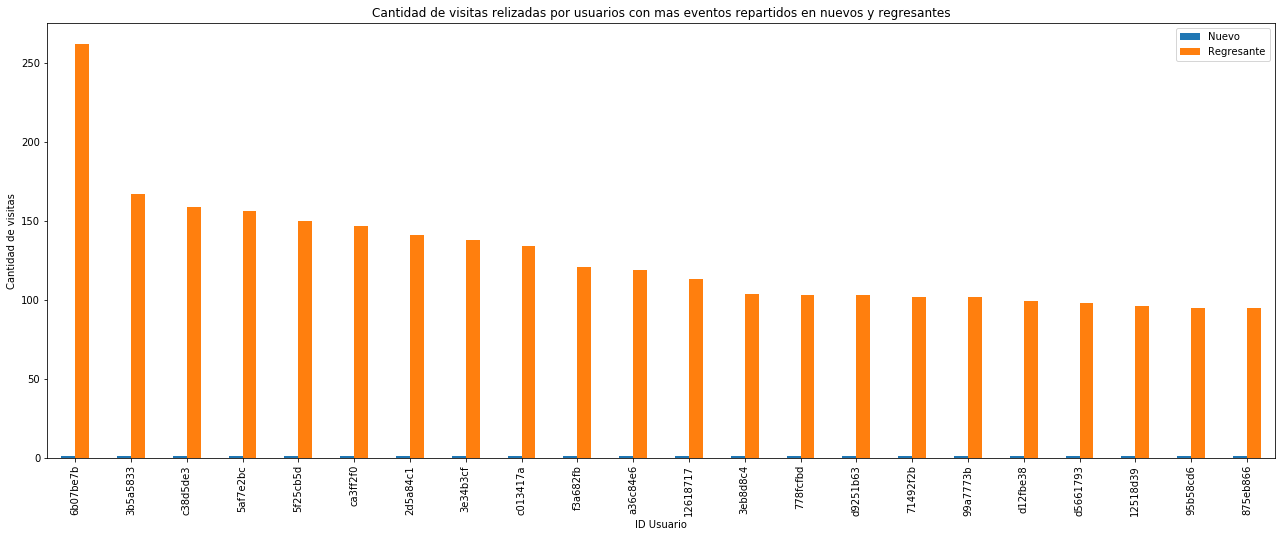

In [44]:
eventos_usuarios = usuario_nuevos.merge(usuario_regresantes, how='inner', on='person')
eventos_usuarios.sort_values(by='cant_eventos_returning', ascending=False, inplace=True)
ax = plt.gca()
eventos_usuarios.head(22).plot(x='person', kind='bar', figsize=(22,8), ax=ax, title='Cantidad de visitas relizadas por usuarios con mas eventos repartidos en nuevos y regresantes');
ax.set_xlabel('ID Usuario');
ax.set_ylabel('Cantidad de visitas')
ax.legend(['Nuevo', 'Regresante']);

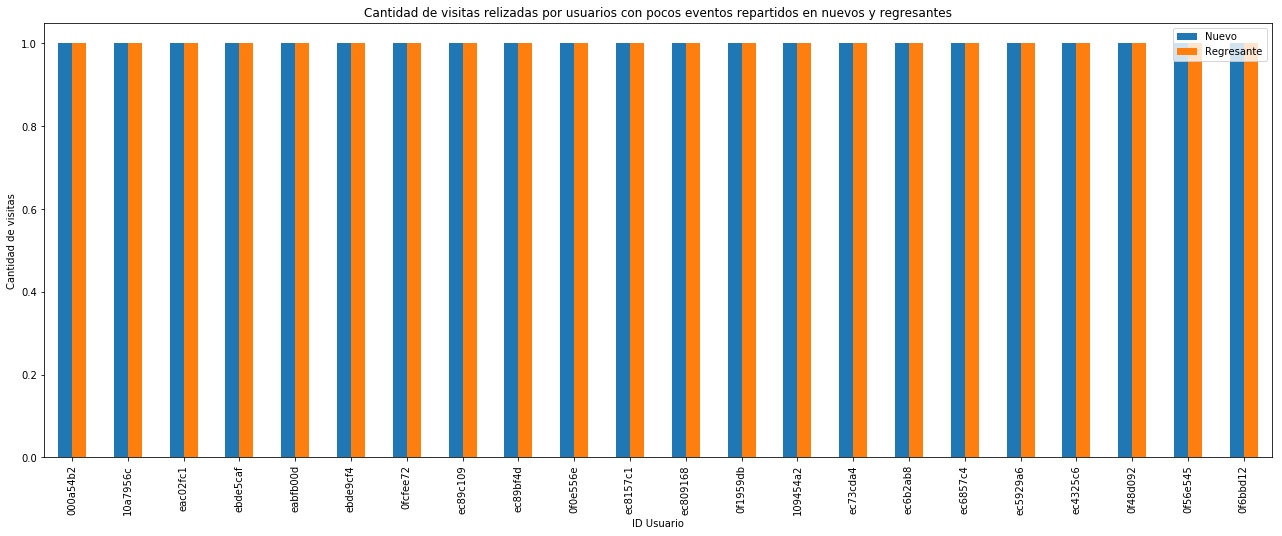

In [45]:
eventos_usuarios_min = eventos_usuarios.sort_values(by='cant_eventos_returning', ascending=True)
ax = plt.gca()
eventos_usuarios_min.head(22).plot(x='person', kind='bar', figsize=(22,8), ax=ax, title='Cantidad de visitas relizadas por usuarios con pocos eventos repartidos en nuevos y regresantes');
ax.set_xlabel('ID Usuario');
ax.set_ylabel('Cantidad de visitas')
ax.legend(['Nuevo', 'Regresante']);

In [46]:
eventos_vistas_productos = eventos_productos.loc[eventos_productos.event == 'viewed product']
eventos_vistas_productos = eventos_vistas_productos.loc[:,['event','person']]
eventos_vistas_productos = eventos_vistas_productos.groupby('person').count()['event'].reset_index()
eventos_vistas_productos.rename({'event':'cant_eventos_vistas'}, axis=1, inplace=True)
eventos_vistas_productos.describe()

,cant_eventos_vistas
count,26316.000000
mean,20.099217
std,52.215289
min,1.000000
25%,2.000000
50%,6.000000
75%,18.000000
max,1525.000000


In [47]:
eventos_compras_productos = eventos_productos.loc[(eventos_productos.event == 'checkout') | (eventos_productos.event == 'conversion')]
eventos_compras_productos = eventos_compras_productos.loc[:,['event','person']]
eventos_compras_productos = eventos_compras_productos.groupby('person').count()['event'].reset_index()
eventos_compras_productos.rename({'event':'cant_eventos_compras'}, axis=1, inplace=True)
eventos_compras_productos.describe()

,cant_eventos_compras
count,27624.000000
mean,1.263648
std,1.400773
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,39.000000


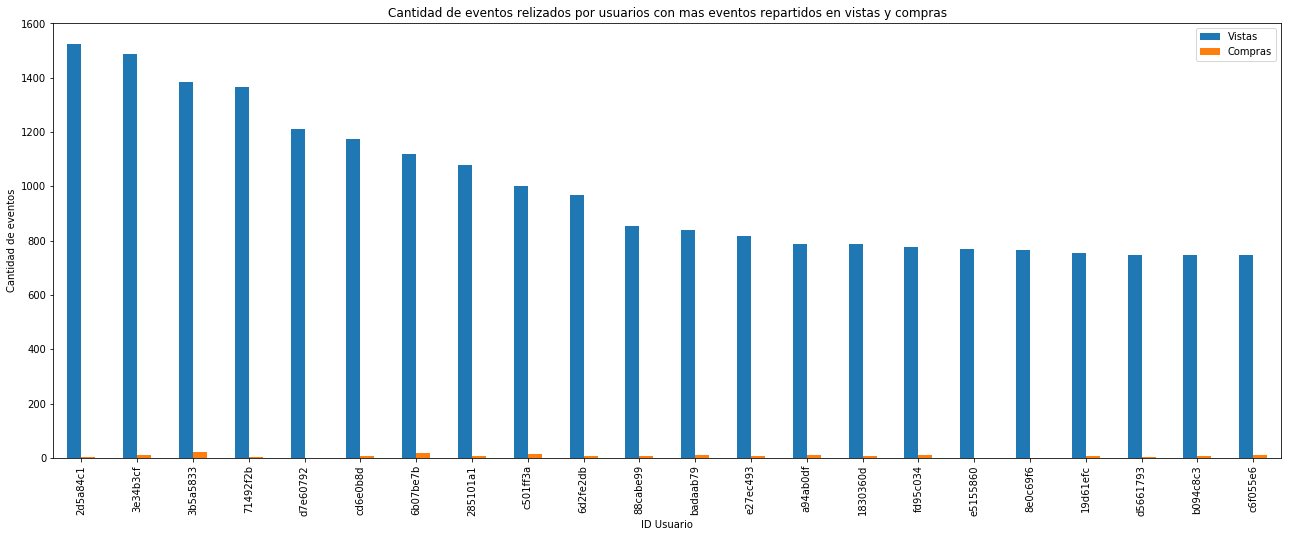

In [48]:
usuario_eventos_productos_max = eventos_vistas_productos.merge(eventos_compras_productos, how='inner', on='person')
usuario_eventos_productos_max.sort_values(by='cant_eventos_vistas', ascending=False, inplace=True)
ax = plt.gca()
usuario_eventos_productos_max.head(22).plot(x='person', kind='bar', figsize=(22,8), ax=ax, title='Cantidad de eventos relizados por usuarios con mas eventos repartidos en vistas y compras');
ax.set_xlabel('ID Usuario')
ax.set_ylabel('Cantidad de eventos')
ax.legend(['Vistas', 'Compras']);

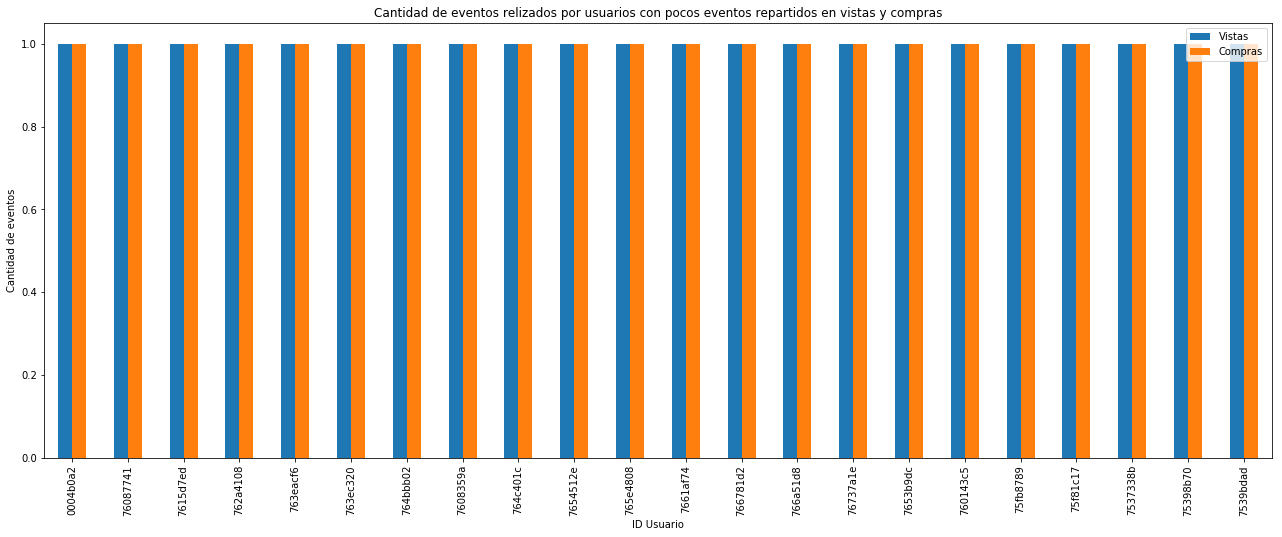

In [49]:
usuario_eventos_productos_min = eventos_vistas_productos.merge(eventos_compras_productos, how='inner', on='person')
usuario_eventos_productos_min.sort_values(by='cant_eventos_vistas', ascending=True, inplace=True)
ax = plt.gca()
usuario_eventos_productos_min.head(22).plot(x='person', kind='bar', figsize=(22,8), ax=ax, title='Cantidad de eventos relizados por usuarios con pocos eventos repartidos en vistas y compras');
ax.set_xlabel('ID Usuario');
ax.set_ylabel('Cantidad de eventos')
ax.legend(['Vistas', 'Compras']);

# Analisis de palabras claves de las busquedas que realizaron los usuarios

In [50]:
#Busquedas son de tipo evento 'searched products'
busquedas = events.loc[:,['event','person','search_term']]
busquedas = busquedas.loc[busquedas.event == 'searched products']
busquedas = busquedas.loc[busquedas.search_term.notnull()]
busquedas.describe()

,event,person,search_term
count,48967,48967,48967
unique,1,7089,5851
top,searched products,e2b0ce1b,Iphone
freq,48967,414,1207


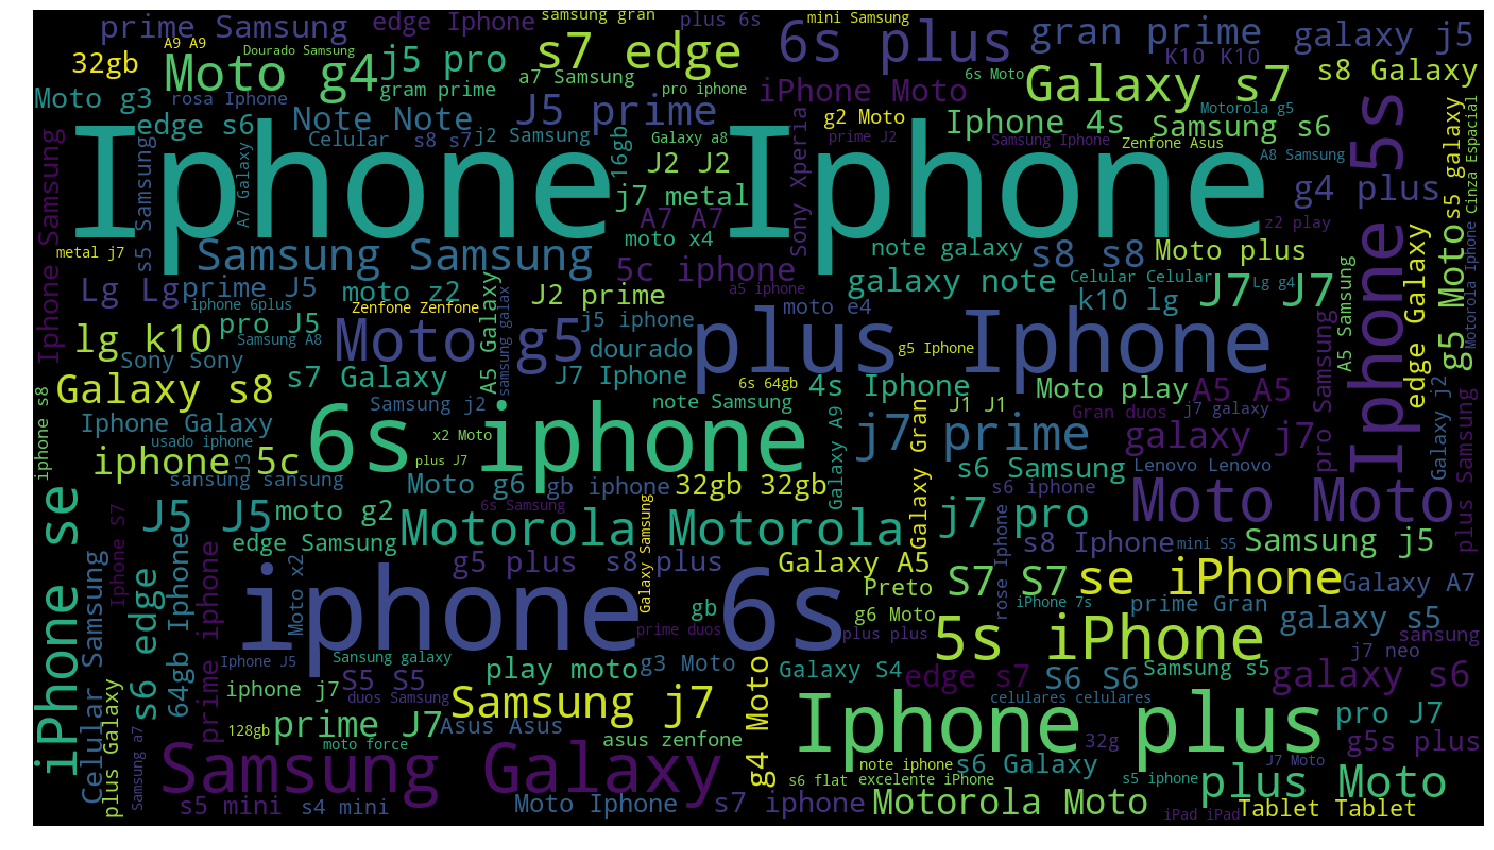

In [51]:
wordcloud = WordCloud(width=1366, height=768).generate(' '.join(busquedas.search_term))
plt.figure(figsize=(30,15))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [52]:
#Agrupamos por person y search_term para eliminar duplicados
busquedas_agrupadas = busquedas.groupby(['person','search_term']).count()['event'].reset_index()
busquedas_agrupadas.drop('event', axis=1, inplace=True)
busquedas_agrupadas.describe()

,person,search_term
count,20647,20647
unique,7089,5851
top,db6f0288,iphone 6
freq,151,346


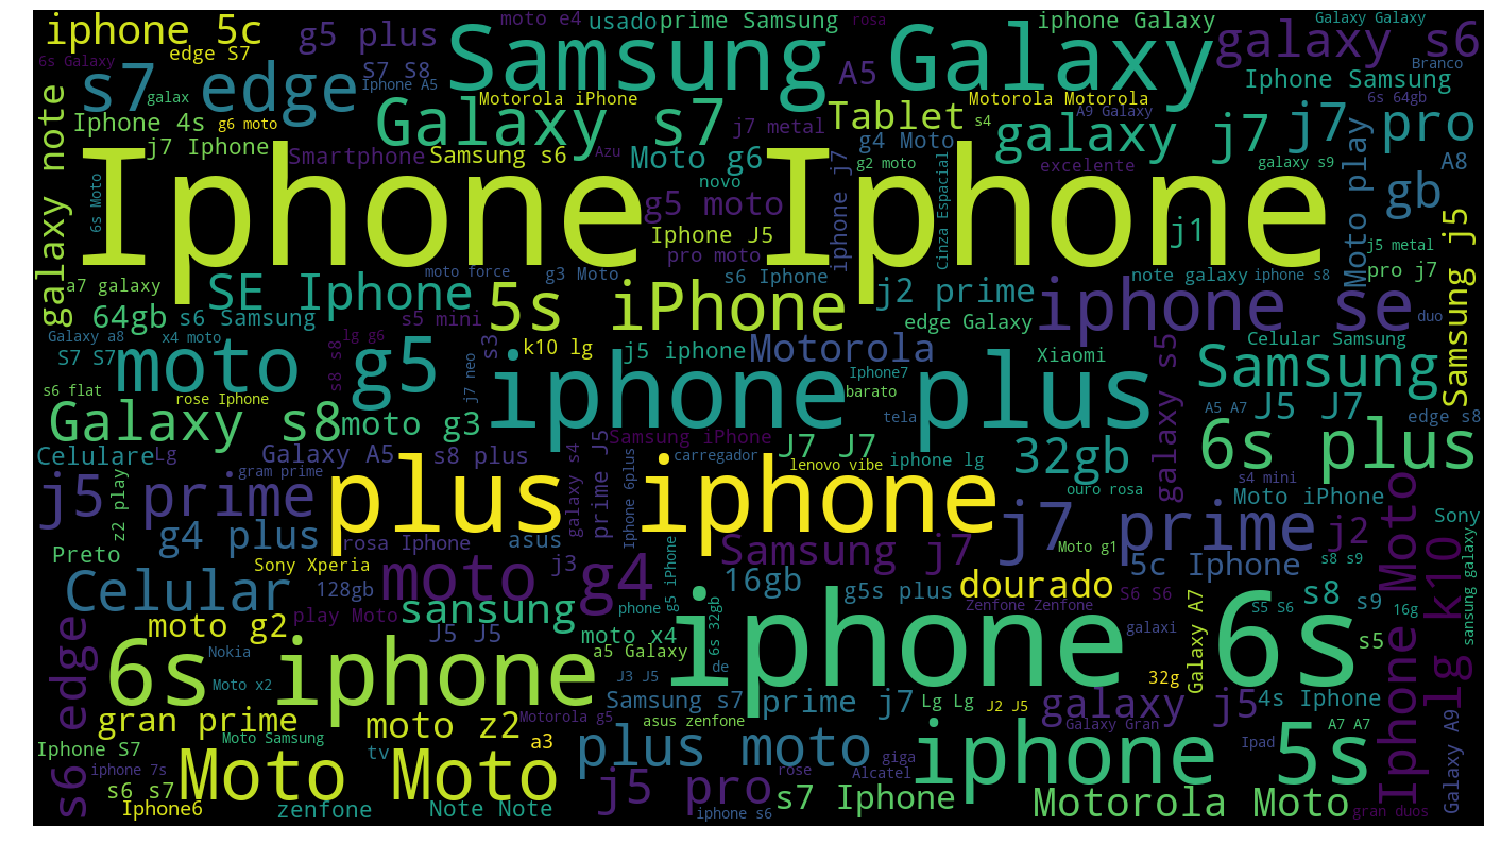

In [53]:
#De 48967 busquedas se agruparon en 20647
wordcloud_agrupadas = WordCloud(width=1366, height=768).generate(' '.join(busquedas_agrupadas.search_term))
plt.figure(figsize=(30,15))
plt.imshow(wordcloud_agrupadas)
plt.axis("off")
plt.show()

Checkeamos si en los eventos de compras de cada usuario se tienen en cuenta las mismas busquedas

In [54]:
compras = events.loc[:,['event','person']]
compras = compras.loc[(compras.event == 'checkout') | (compras.event == 'conversion')]
compras.describe()

,event,person
count,34907,34907
unique,2,27624
top,checkout,52a4edd3
freq,33735,39


In [55]:
#Hay 27624 usuarios que compraron productos
#Hay 7089 usuarios que realizaron busquedas 
compras = compras.groupby('person').count()['event'].reset_index()
compras.drop('event', axis=1, inplace=True)
compras.describe()

,person
count,27624
unique,27624
top,f0634dc7
freq,1


In [56]:
busquedas_compras = pd.merge(compras, busquedas, on='person', how='inner')
busquedas_compras.describe()

,person,event,search_term
count,48967,48967,48967
unique,7089,1,5851
top,e2b0ce1b,searched products,Iphone
freq,414,48967,1207


Por lo tanto, las 7089 usuarios que realizaron la busquedas forman parte de los 27624 que realizaron las compras.

Checkeamos si en los eventos de vistas de productos de cada usuario se tienen en cuenta las mismas busquedas

In [57]:
vistas_productos = events.loc[:,['event','person']]
vistas_productos = vistas_productos.loc[(vistas_productos.event == 'viewed product')]
vistas_productos.describe()

,event,person
count,528931,528931
unique,1,26316
top,viewed product,2d5a84c1
freq,528931,1525


In [58]:
vistas_productos = vistas_productos.groupby('person').count()['event'].reset_index()
vistas_productos.drop('event', axis=1, inplace=True)
vistas_productos.describe()

,person
count,26316
unique,26316
top,f0634dc7
freq,1


In [59]:
vistas_productos = vistas_productos.merge(compras, how='inner', on='person')
vistas_productos.describe()

,person
count,26316
unique,26316
top,f0634dc7
freq,1


Por lo tanto, todas los usuarios que vieron algunos productos, terminaron comprando al menos un producto.
Hay 26316 usuarios que vieron algunos productos.
Hay 27624 usuarios que compraron algunos productos.
Hay 1308 usuarios que compraron sin ver el producto.
Donde los 7089 usuarios que realizaron las busquedas forman parte de esta relacion.